# EEG Data Structure Visualization
จาก `preprocess_rawEEG.py` — แสดงโครงสร้างของ data ทั้งในรูป raw EDF และ preprocessed `.mat` (HDF5)

In [1]:
import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

# ── Paths (ตรงกับ preprocess_rawEEG.py) ───────────────────────────────────────
RAW_EEG_DIR = '/home/nummm/Documents/CEPP/rawEEG'
OUTPUT_DIR  = '/home/nummm/Documents/CEPP/l-seqsleepnet/custom/preprocessing_output'

# Config ตรงกับ preprocess_rawEEG.py
SAMPLERATE    = 100
EPOCH_SEC     = 30
EPOCH_SAMPLES = SAMPLERATE * EPOCH_SEC   # 3000 samples
FREQ_BINS     = 129
TIME_FRAMES   = 29
NCLASS        = 5

STAGE_NAMES  = {0: 'Wake (W)', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
STAGE_COLORS = {0: '#e74c3c', 1: '#f39c12', 2: '#2ecc71', 3: '#3498db', 4: '#9b59b6'}
STAGE_MAP = {
    'WK': 0, 'W': 0, 'WAKE': 0,
    'N1': 1, '1': 1,
    'N2': 2, '2': 2,
    'N3': 3, '3': 3, 'N4': 3, '4': 3,
    'REM': 4, 'R': 4,
}

subject_ids = sorted([
    d for d in os.listdir(RAW_EEG_DIR)
    if os.path.isdir(os.path.join(RAW_EEG_DIR, d))
])

print(f'Paths configured:')
print(f'  RAW_EEG_DIR : {RAW_EEG_DIR}')
print(f'  OUTPUT_DIR  : {OUTPUT_DIR}')
print(f'  Total subjects: {len(subject_ids)}')

Paths configured:
  RAW_EEG_DIR : /home/nummm/Documents/CEPP/rawEEG
  OUTPUT_DIR  : /home/nummm/Documents/CEPP/l-seqsleepnet/custom/preprocessing_output
  Total subjects: 70


## 1. โครงสร้าง Input — Raw EDF + CSV Files

In [2]:
print('=' * 65)
print('INPUT: Raw EEG Directory Structure')
print('=' * 65)

if not os.path.isdir(RAW_EEG_DIR):
    print(f'  [ERROR] Directory not found: {RAW_EEG_DIR}')
else:
    print(f'Total subjects found : {len(subject_ids)}')
    print()

    SHOW_N = 3
    print(f'Sample folders (first {SHOW_N}):')
    for sid in subject_ids[:SHOW_N]:
        sid_path = os.path.join(RAW_EEG_DIR, sid)
        files = os.listdir(sid_path)
        has_edf  = 'edf_signals.edf'    in files
        has_hyp  = 'csv_hypnogram.csv'  in files
        has_evt  = 'csv_events.csv'     in files

        edf_size = ''
        if has_edf:
            edf_bytes = os.path.getsize(os.path.join(sid_path, 'edf_signals.edf'))
            edf_size = f'({edf_bytes/1e6:.1f} MB)'

        print(f'  {sid}/')
        print(f'    ├── edf_signals.edf   : {"✓" if has_edf else "✗ MISSING"} {edf_size}')
        print(f'    ├── csv_hypnogram.csv : {"✓" if has_hyp else "✗ MISSING"}')
        print(f'    └── csv_events.csv   : {"✓" if has_evt else "✗ MISSING"}')
        print()

    n_edf = sum(1 for sid in subject_ids if os.path.exists(os.path.join(RAW_EEG_DIR, sid, 'edf_signals.edf')))
    n_hyp = sum(1 for sid in subject_ids if os.path.exists(os.path.join(RAW_EEG_DIR, sid, 'csv_hypnogram.csv')))
    print(f'Summary:')
    print(f'  Subjects with edf_signals.edf   : {n_edf}/{len(subject_ids)}')
    print(f'  Subjects with csv_hypnogram.csv : {n_hyp}/{len(subject_ids)}')

INPUT: Raw EEG Directory Structure
Total subjects found : 70

Sample folders (first 3):
  00000396-159547/
    ├── edf_signals.edf   : ✓ (8.6 MB)
    ├── csv_hypnogram.csv : ✓
    └── csv_events.csv   : ✓

  00000399-159547/
    ├── edf_signals.edf   : ✓ (218.5 MB)
    ├── csv_hypnogram.csv : ✓
    └── csv_events.csv   : ✓

  00000400-159547/
    ├── edf_signals.edf   : ✓ (266.7 MB)
    ├── csv_hypnogram.csv : ✓
    └── csv_events.csv   : ✓

Summary:
  Subjects with edf_signals.edf   : 70/70
  Subjects with csv_hypnogram.csv : 70/70


## 2. โครงสร้าง Raw EEG Signal (EDF File) — 1 Subject

In [3]:
import mne
mne.set_log_level('WARNING')

sample_subject = None
for sid in subject_ids:
    edf_path = os.path.join(RAW_EEG_DIR, sid, 'edf_signals.edf')
    if os.path.exists(edf_path):
        sample_subject = sid
        break

if sample_subject is None:
    print('[ERROR] No subject with EDF found.')
else:
    edf_path = os.path.join(RAW_EEG_DIR, sample_subject, 'edf_signals.edf')
    print('=' * 65)
    print(f'RAW EDF STRUCTURE  —  Subject: {sample_subject}')
    print('=' * 65)

    raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)

    print(f'File path         : {edf_path}')
    print(f'Sample rate       : {raw.info["sfreq"]} Hz')
    print(f'Duration          : {raw.times[-1]:.1f} s  ({raw.times[-1]/60:.1f} min)')
    print(f'Number of channels: {len(raw.ch_names)}')
    print(f'Channel names     : {raw.ch_names}')
    print()

    total_samples_raw = int(raw.times[-1] * raw.info['sfreq'])
    epoch_samples_raw = int(raw.info['sfreq'] * EPOCH_SEC)
    n_epochs_raw = total_samples_raw // epoch_samples_raw
    print(f'Estimated epochs (before resample): {n_epochs_raw}')
    print()

    total_samples_100 = int(raw.times[-1] * SAMPLERATE)
    n_epochs_100 = total_samples_100 // EPOCH_SAMPLES
    print(f'After resample to {SAMPLERATE} Hz:')
    print(f'  Total samples : {total_samples_100}')
    print(f'  Epochs        : {n_epochs_100}  (each = {EPOCH_SAMPLES} samples = {EPOCH_SEC}s)')

    del raw

RAW EDF STRUCTURE  —  Subject: 00000396-159547
File path         : /home/nummm/Documents/CEPP/rawEEG/00000396-159547/edf_signals.edf
Sample rate       : 500.0 Hz
Duration          : 866.0 s  (14.4 min)
Number of channels: 34
Channel names     : ['EOG LOC-A2', 'EOG ROC-A2', 'EEG F3-A2', 'EEG F4-A1', 'EEG A1-A2', 'EEG C3-A2', 'EEG C4-A1', 'EEG O1-A2', 'EEG O2-A1', 'EMG Chin', 'EMG Aux1', 'EMG Aux2', 'ECG I', 'ECG II', 'Snore-0', 'Flow Patient-0', 'Flow Patient-1', 'Effort THO', 'Effort ABD', 'SpO2', 'PulseRate', 'Pleth', 'Leg 1', 'Leg 2', 'Body', 'Flow Patient-2', 'xPAP CPAP', 'xPAP EPAP', 'xPAP IPAP', 'Leak Total', 'Snore-1', 'RespRate', 'BreathRate', 'ECG V']

Estimated epochs (before resample): 28

After resample to 100 Hz:
  Total samples : 86599
  Epochs        : 28  (each = 3000 samples = 30s)


## 3. โครงสร้าง Hypnogram CSV — Labels ต่อ Epoch

In [4]:
if sample_subject:
    hyp_path = os.path.join(RAW_EEG_DIR, sample_subject, 'csv_hypnogram.csv')
    print('=' * 65)
    print(f'HYPNOGRAM CSV  —  Subject: {sample_subject}')
    print('=' * 65)

    if not os.path.exists(hyp_path):
        print('[ERROR] csv_hypnogram.csv not found')
    else:
        df_hyp = pd.read_csv(hyp_path)
        df_hyp.columns = df_hyp.columns.str.strip()

        print(f'File path     : {hyp_path}')
        print(f'Total rows    : {len(df_hyp)}')
        print(f'Columns       : {df_hyp.columns.tolist()}')
        print()
        print('First 5 rows:')
        print(df_hyp.head(5).to_string(index=False))
        print()

        stage_col = next((c for c in df_hyp.columns if 'stage' in c.lower()), None)
        if stage_col:
            df_hyp['label'] = df_hyp[stage_col].str.strip().str.upper().map(STAGE_MAP)
            counts = df_hyp['label'].value_counts().sort_index()
            ns_count = df_hyp['label'].isna().sum()
            print('Sleep stage distribution (mapped labels):')
            for lbl, cnt in counts.items():
                bar = '█' * int(cnt / counts.max() * 30)
                stage_name = STAGE_NAMES.get(int(lbl), '?')
                print(f'  Stage {int(lbl)} ({stage_name:8s}) : {cnt:4d} epochs  {bar}')
            print(f'  NS (unmapped)  : {ns_count:4d} epochs')
        print()

HYPNOGRAM CSV  —  Subject: 00000396-159547
File path     : /home/nummm/Documents/CEPP/rawEEG/00000396-159547/csv_hypnogram.csv
Total rows    : 29
Columns       : ['Epoch Number', 'Start Time', 'Sleep Stage']

First 5 rows:
 Epoch Number Start Time Sleep Stage
            1 5:22:25 AM          NS
            2 5:22:55 AM          NS
            3 5:23:25 AM          NS
            4 5:23:55 AM          NS
            5 5:24:25 AM          NS

Sleep stage distribution (mapped labels):
  NS (unmapped)  :   29 epochs



## 4. โครงสร้าง Preprocessed `.mat` (HDF5) — Output ของ preprocess_rawEEG.py

In [5]:
print('=' * 65)
print('OUTPUT: Preprocessed .mat (HDF5) Structure')
print('=' * 65)

if not os.path.isdir(OUTPUT_DIR):
    print(f'[ERROR] Output directory not found: {OUTPUT_DIR}')
else:
    mat_files = sorted([f for f in os.listdir(OUTPUT_DIR) if f.endswith('_eeg.mat')])
    print(f'Total .mat files found: {len(mat_files)}')
    print()

    if not mat_files:
        print('[ERROR] No .mat files found in output directory.')
    else:
        sample_mat = mat_files[0]
        mat_path = os.path.join(OUTPUT_DIR, sample_mat)

        print(f'Inspecting: {sample_mat}')
        print()

        with h5py.File(mat_path, 'r') as f:
            print('HDF5 Datasets:')
            for key in f.keys():
                ds = f[key]
                print(f'  [{key}]')
                print(f'    dtype : {ds.dtype}')
                print(f'    shape : {ds.shape}')
                print()

            X2    = f['X2'][:]
            y_hot = f['y'][:]
            label = f['label'][:]

        n_epochs = X2.shape[2]
        print('─' * 50)
        print('Dataset Details:')
        print()
        print(f'X2  (Spectrogram):')
        print(f'  Stored shape : {X2.shape}   → (TIME_FRAMES, FREQ_BINS, N_EPOCHS)')
        print(f'  After model transpose (2,1,0): {X2.transpose(2,1,0).shape}')
        print(f'                   → (N_EPOCHS, FREQ_BINS, TIME_FRAMES)')
        print(f'  Value range  : min={X2.min():.3f}, max={X2.max():.3f}, mean={X2.mean():.3f}')
        print()

        print(f'y   (One-hot label):')
        print(f'  Stored shape : {y_hot.shape}   → (N_CLASS, N_EPOCHS)')
        print(f'  N_CLASS = {y_hot.shape[0]} stages')
        print()

        print(f'label (Integer label):')
        print(f'  Stored shape : {label.shape}   → (1, N_EPOCHS)')
        print()

        print(f'Total epochs in this file: {n_epochs}')

        label_flat = label[0].astype(int)
        unique, counts = np.unique(label_flat, return_counts=True)
        print()
        print('Sleep stage distribution (from .mat label):')
        for lbl, cnt in zip(unique, counts):
            bar = '█' * int(cnt / counts.max() * 30)
            stage_name = STAGE_NAMES.get(int(lbl), '?')
            print(f'  Stage {int(lbl)} ({stage_name:8s}) : {cnt:4d} epochs  {bar}')

OUTPUT: Preprocessed .mat (HDF5) Structure
Total .mat files found: 65

Inspecting: 00000396-159547_eeg.mat

HDF5 Datasets:
  [X2]
    dtype : float32
    shape : (29, 129, 28)

  [label]
    dtype : float32
    shape : (1, 28)

  [y]
    dtype : float32
    shape : (5, 28)

──────────────────────────────────────────────────
Dataset Details:

X2  (Spectrogram):
  Stored shape : (29, 129, 28)   → (TIME_FRAMES, FREQ_BINS, N_EPOCHS)
  After model transpose (2,1,0): (28, 129, 29)
                   → (N_EPOCHS, FREQ_BINS, TIME_FRAMES)
  Value range  : min=-23.026, max=0.000, mean=-20.625

y   (One-hot label):
  Stored shape : (5, 28)   → (N_CLASS, N_EPOCHS)
  N_CLASS = 5 stages

label (Integer label):
  Stored shape : (1, 28)   → (1, N_EPOCHS)

Total epochs in this file: 28

Sleep stage distribution (from .mat label):
  Stage 0 (Wake (W)) :   28 epochs  ██████████████████████████████


## 5. สรุปโครงสร้าง Pipeline ทั้งหมด (Print Summary)

In [6]:
print('=' * 65)
print('PIPELINE SUMMARY: preprocess_rawEEG.py')
print('=' * 65)
print()
print('┌─────────────────────────────────────────────────────────┐')
print('│  INPUT (per subject)                                    │')
print('│  rawEEG/[id]/                                           │')
print('│  ├── edf_signals.edf     → raw EEG signal              │')
print('│  ├── csv_hypnogram.csv   → sleep stage labels/epoch     │')
print('│  └── csv_events.csv      → (not used in preprocess)     │')
print('└──────────────────────┬──────────────────────────────────┘')
print('                       │')
print('                       ▼')
print('┌─────────────────────────────────────────────────────────┐')
print('│  PREPROCESSING STEPS                                    │')
print('│  1. Load EDF  (mne.io.read_raw_edf)                    │')
print('│  2. Pick EEG channels → use only 1st channel            │')
print('│  3. Resample → 100 Hz                                   │')
print(f'│  4. Epoch signal    ({EPOCH_SAMPLES} samples = {EPOCH_SEC}s each)         │')
print(f'│  5. STFT Spectrogram per epoch                          │')
print(f'│       nperseg={256}, noverlap={148}, nfft={256}, window=hann  │')
print(f'│       Output: log-power spec ({TIME_FRAMES}, {FREQ_BINS}) per epoch      │')
print('│  6. Parse hypnogram → integer label (0-indexed)         │')
print('│  7. Stack → 3D array (TIME_FRAMES, FREQ_BINS, N_EPOCHS) │')
print('└──────────────────────┬──────────────────────────────────┘')
print('                       │')
print('                       ▼')
print('┌─────────────────────────────────────────────────────────┐')
print('│  OUTPUT (HDF5 .mat per subject)                         │')
print('│  preprocessing_output/[id]_eeg.mat                      │')
print('│                                                         │')
print(f'│  X2    : ({TIME_FRAMES:2d}, {FREQ_BINS:3d}, N) → spectrogram (TIME×FREQ×EPOCH)│')
print(f'│  y     : ( 5,   N) → one-hot sleep stage labels        │')
print(f'│  label : ( 1,   N) → integer labels 0-4                │')
print('│                                                         │')
print('│  Label mapping:                                         │')
print('│    0: Wake (WK/W/WAKE)                                  │')
print('│    1: N1                                                │')
print('│    2: N2                                                │')
print('│    3: N3 / N4                                           │')
print('│    4: REM (R)                                           │')
print('└─────────────────────────────────────────────────────────┘')
print()
print('After datagenerator_from_list_v3.py reads X2 and transposes (2,1,0):')
print(f'  X2 shape becomes (N, {FREQ_BINS}, {TIME_FRAMES})  → used as (N_epochs, freq_bins, time_frames)')

PIPELINE SUMMARY: preprocess_rawEEG.py

┌─────────────────────────────────────────────────────────┐
│  INPUT (per subject)                                    │
│  rawEEG/[id]/                                           │
│  ├── edf_signals.edf     → raw EEG signal              │
│  ├── csv_hypnogram.csv   → sleep stage labels/epoch     │
│  └── csv_events.csv      → (not used in preprocess)     │
└──────────────────────┬──────────────────────────────────┘
                       │
                       ▼
┌─────────────────────────────────────────────────────────┐
│  PREPROCESSING STEPS                                    │
│  1. Load EDF  (mne.io.read_raw_edf)                    │
│  2. Pick EEG channels → use only 1st channel            │
│  3. Resample → 100 Hz                                   │
│  4. Epoch signal    (3000 samples = 30s each)         │
│  5. STFT Spectrogram per epoch                          │
│       nperseg=256, noverlap=148, nfft=256, window=hann  │
│       Output

---
## 6. Statistical Overview — EDF Files (ทุก Subject)
รวบรวมสถิติจาก EDF ทุก subject แล้วแสดงด้วย chart

In [7]:
# ── รวบรวมข้อมูลจาก EDF header (ไม่โหลด signal เข้า RAM) ─────────────────────
import mne
mne.set_log_level('WARNING')

edf_records = []

print('Scanning EDF files across all subjects...')
for sid in subject_ids:
    edf_path = os.path.join(RAW_EEG_DIR, sid, 'edf_signals.edf')
    if not os.path.exists(edf_path):
        continue
    try:
        raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
        duration_s   = raw.times[-1]
        sfreq        = raw.info['sfreq']
        n_channels   = len(raw.ch_names)
        file_size_mb = os.path.getsize(edf_path) / 1e6
        n_epochs_est = int(duration_s * SAMPLERATE) // EPOCH_SAMPLES
        del raw
        edf_records.append({
            'subject':      sid,
            'duration_min': duration_s / 60,
            'sfreq_hz':     sfreq,
            'n_channels':   n_channels,
            'file_mb':      file_size_mb,
            'n_epochs':     n_epochs_est,
        })
    except Exception as e:
        print(f'  [WARN] {sid}: {e}')

df_edf = pd.DataFrame(edf_records)
print(f'Done. Collected info for {len(df_edf)} subjects with EDF.\n')

print('EDF Statistics Summary (all subjects):')
stats = df_edf[['duration_min', 'file_mb', 'n_channels', 'sfreq_hz', 'n_epochs']].describe()
print(stats.to_string())
print()

print('Unique values:')
for col in ['sfreq_hz', 'n_channels']:
    print(f'  {col:15s}: {sorted(df_edf[col].unique().tolist())}')

Scanning EDF files across all subjects...
Done. Collected info for 70 subjects with EDF.

EDF Statistics Summary (all subjects):
       duration_min     file_mb  n_channels  sfreq_hz     n_epochs
count     70.000000   70.000000   70.000000      70.0    70.000000
mean     249.400205  137.616643   35.457143     500.0   498.271429
std      198.184774  111.162091    2.004963       0.0   396.380469
min        1.666633    0.996360   34.000000     500.0     3.000000
25%       31.924967   16.776317   34.000000     500.0    63.250000
50%      370.008300  189.643981   34.000000     500.0   739.500000
75%      420.495800  238.377194   37.000000     500.0   840.750000
max      500.633300  296.604172   39.000000     500.0  1001.000000

Unique values:
  sfreq_hz       : [500.0]
  n_channels     : [34, 37, 39]


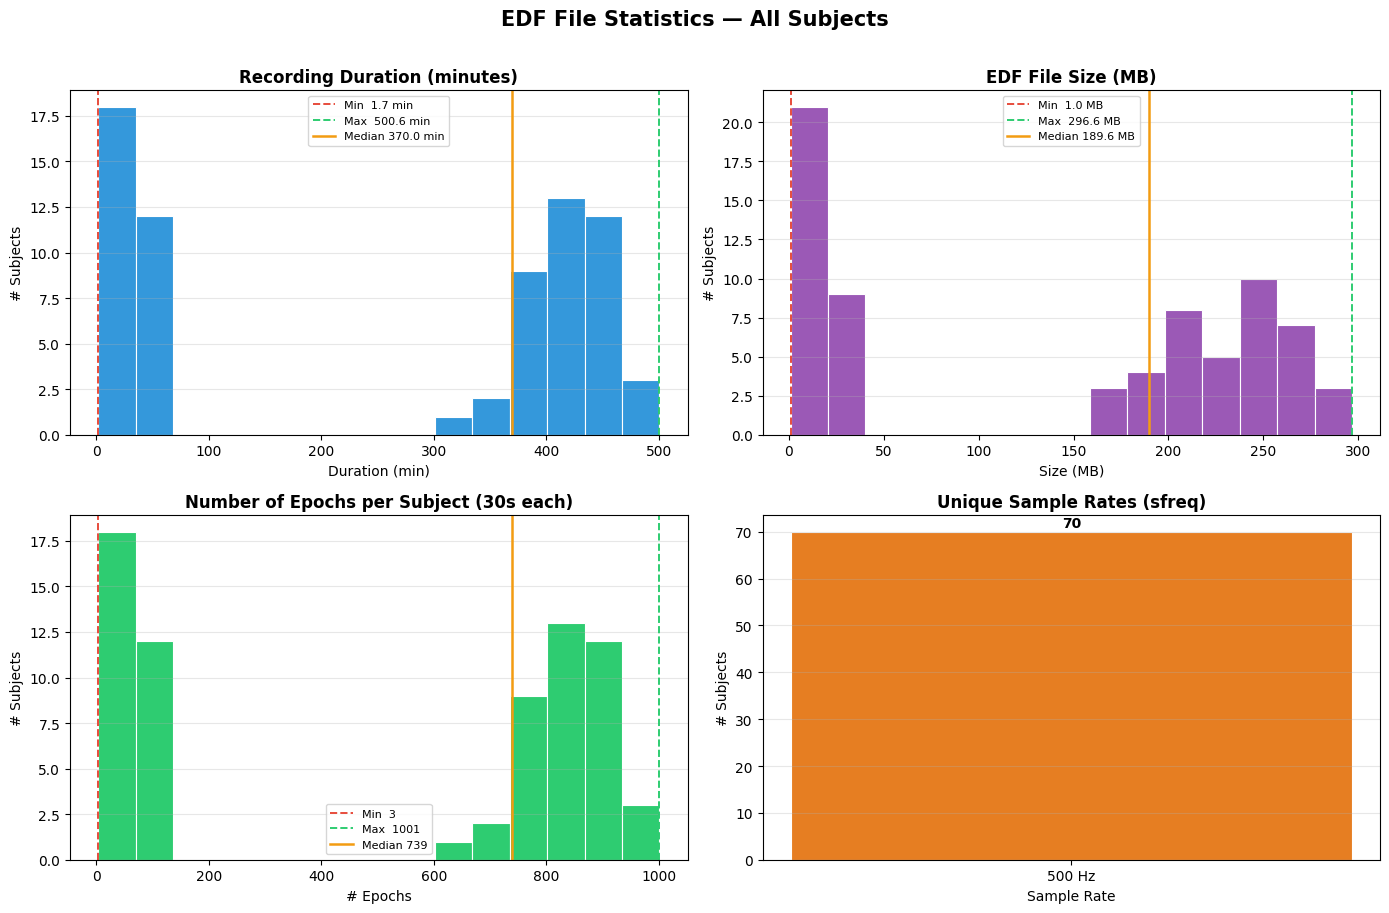

In [8]:
# ── Charts: EDF Stats ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
fig.suptitle('EDF File Statistics — All Subjects', fontsize=15, fontweight='bold', y=1.01)

ACCENT = '#3498db'

# 1. Duration histogram
ax = axes[0, 0]
ax.hist(df_edf['duration_min'], bins=15, color=ACCENT, edgecolor='white', linewidth=0.8)
mn, mx, med = df_edf['duration_min'].min(), df_edf['duration_min'].max(), df_edf['duration_min'].median()
ax.axvline(mn,  color='#e74c3c', linestyle='--', linewidth=1.4, label=f'Min  {mn:.1f} min')
ax.axvline(mx,  color='#2ecc71', linestyle='--', linewidth=1.4, label=f'Max  {mx:.1f} min')
ax.axvline(med, color='#f39c12', linestyle='-',  linewidth=1.8, label=f'Median {med:.1f} min')
ax.set_title('Recording Duration (minutes)', fontweight='bold')
ax.set_xlabel('Duration (min)'); ax.set_ylabel('# Subjects')
ax.legend(fontsize=8); ax.grid(axis='y', alpha=0.3)

# 2. File size histogram
ax = axes[0, 1]
ax.hist(df_edf['file_mb'], bins=15, color='#9b59b6', edgecolor='white', linewidth=0.8)
mn, mx, med = df_edf['file_mb'].min(), df_edf['file_mb'].max(), df_edf['file_mb'].median()
ax.axvline(mn,  color='#e74c3c', linestyle='--', linewidth=1.4, label=f'Min  {mn:.1f} MB')
ax.axvline(mx,  color='#2ecc71', linestyle='--', linewidth=1.4, label=f'Max  {mx:.1f} MB')
ax.axvline(med, color='#f39c12', linestyle='-',  linewidth=1.8, label=f'Median {med:.1f} MB')
ax.set_title('EDF File Size (MB)', fontweight='bold')
ax.set_xlabel('Size (MB)'); ax.set_ylabel('# Subjects')
ax.legend(fontsize=8); ax.grid(axis='y', alpha=0.3)

# 3. Epochs per subject
ax = axes[1, 0]
ax.hist(df_edf['n_epochs'], bins=15, color='#2ecc71', edgecolor='white', linewidth=0.8)
mn, mx, med = df_edf['n_epochs'].min(), df_edf['n_epochs'].max(), df_edf['n_epochs'].median()
ax.axvline(mn,  color='#e74c3c', linestyle='--', linewidth=1.4, label=f'Min  {int(mn)}')
ax.axvline(mx,  color='#2ecc71', linestyle='--', linewidth=1.4, label=f'Max  {int(mx)}')
ax.axvline(med, color='#f39c12', linestyle='-',  linewidth=1.8, label=f'Median {int(med)}')
ax.set_title('Number of Epochs per Subject (30s each)', fontweight='bold')
ax.set_xlabel('# Epochs'); ax.set_ylabel('# Subjects')
ax.legend(fontsize=8); ax.grid(axis='y', alpha=0.3)

# 4. Unique sample rate bar
ax = axes[1, 1]
sfreq_counts = df_edf['sfreq_hz'].value_counts().sort_index()
bars = ax.bar([str(int(v)) + ' Hz' for v in sfreq_counts.index],
              sfreq_counts.values, color='#e67e22', edgecolor='white', linewidth=0.8)
ax.set_title('Unique Sample Rates (sfreq)', fontweight='bold')
ax.set_xlabel('Sample Rate'); ax.set_ylabel('# Subjects')
for bar, val in zip(bars, sfreq_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, str(val),
            ha='center', va='bottom', fontsize=10, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
print()

## 7. Statistical Overview — Hypnogram CSV (ทุก Subject)
วิเคราะห์ sleep stage distribution รวมถึง NS (Not Scored / unmapped) จาก hypnogram ของทุก subject

In [9]:
# ── รวบรวม hypnogram จากทุก subject ──────────────────────────────────────────
hyp_records = []
all_stages_raw = []   # รวมทุก raw stage token ที่เจอ
cols_seen = set()

print('Scanning Hypnogram CSV files...')
for sid in subject_ids:
    hyp_path = os.path.join(RAW_EEG_DIR, sid, 'csv_hypnogram.csv')
    if not os.path.exists(hyp_path):
        continue
    try:
        df = pd.read_csv(hyp_path)
        df.columns = df.columns.str.strip()
        cols_seen.update(df.columns.tolist())

        stage_col = next((c for c in df.columns if 'stage' in c.lower()), None)
        if stage_col is None:
            continue

        stages_raw = df[stage_col].str.strip().str.upper()
        all_stages_raw.extend(stages_raw.tolist())
        labels = stages_raw.map(STAGE_MAP)   # NaN = unmapped (NS)

        rec = {'subject': sid, 'n_epochs': len(labels)}
        for s in range(5):
            rec[f'stage_{s}'] = (labels == s).sum()
        rec['stage_ns'] = labels.isna().sum()   # NS = Not Scored / unmapped
        hyp_records.append(rec)
    except Exception as e:
        print(f'  [WARN] {sid}: {e}')

df_hyp_all = pd.DataFrame(hyp_records)
print(f'Done. Collected hypnogram for {len(df_hyp_all)} subjects.\n')

# ── Unique column names ───────────────────────────────────────────────────────
print('Unique column names seen across all hypnogram CSV files:')
for c in sorted(cols_seen):
    print(f'  • {c}')
print()

# ── Unique raw stage tokens ───────────────────────────────────────────────────
unique_raw = sorted(set(all_stages_raw))
print(f'Unique sleep stage tokens (raw, before mapping): {unique_raw}\n')

# ── Stats per sleep stage (including NS) ─────────────────────────────────────
print('Epochs per stage — Statistics across subjects:')
header = f'  {"Stage":<16}  {"Total":>8}  {"Min":>6}  {"Max":>6}  {"Mean":>7}  {"Median":>7}'
print(header)
print('  ' + '-' * (len(header) - 2))

for s in range(5):
    col  = f'stage_{s}'
    name = STAGE_NAMES[s]
    total = df_hyp_all[col].sum()
    mn    = df_hyp_all[col].min()
    mx    = df_hyp_all[col].max()
    mean  = df_hyp_all[col].mean()
    med   = df_hyp_all[col].median()
    print(f'  {name:<16}  {total:>8,}  {int(mn):>6}  {int(mx):>6}  {mean:>7.1f}  {med:>7.1f}')

# NS (Not Scored / unmapped)
ns_col = df_hyp_all['stage_ns']
print(f'  {"NS (unmapped)":<16}  {ns_col.sum():>8,}  {int(ns_col.min()):>6}  {int(ns_col.max()):>6}  {ns_col.mean():>7.1f}  {ns_col.median():>7.1f}')

# NREM total row
print('  ' + '-' * (len(header) - 2))
nrem_col = df_hyp_all['stage_1'] + df_hyp_all['stage_2'] + df_hyp_all['stage_3']
print(f'  {"NREM (N1+N2+N3)":<16}  {nrem_col.sum():>8,}  {int(nrem_col.min()):>6}  {int(nrem_col.max()):>6}  {nrem_col.mean():>7.1f}  {nrem_col.median():>7.1f}')

total_epochs = df_hyp_all['n_epochs'].sum()
print(f'\n  Total epochs (all subjects): {total_epochs:,}')
print(f'  Min epochs per subject     : {int(df_hyp_all["n_epochs"].min())}')
print(f'  Max epochs per subject     : {int(df_hyp_all["n_epochs"].max())}')
print(f'  Mean epochs per subject    : {df_hyp_all["n_epochs"].mean():.1f}')

Scanning Hypnogram CSV files...
Done. Collected hypnogram for 70 subjects.

Unique column names seen across all hypnogram CSV files:
  • Epoch Number
  • Sleep Stage
  • Start Time

Unique sleep stage tokens (raw, before mapping): ['N1', 'N2', 'N3', 'NS', 'REM', 'WK']

Epochs per stage — Statistics across subjects:
  Stage                Total     Min     Max     Mean   Median
  ------------------------------------------------------------
  Wake (W)             5,475       0     417     78.2     63.0
  N1                   2,710       0     171     38.7     37.0
  N2                  14,238       0     543    203.4    292.5
  N3                   5,739       0     265     82.0     73.5
  REM                  5,258       0     226     75.1     77.5
  NS (unmapped)        1,649       0     148     23.6      1.5
  ------------------------------------------------------------
  NREM (N1+N2+N3)     22,687       0     735    324.1    480.0

  Total epochs (all subjects): 35,069
  Min epochs p

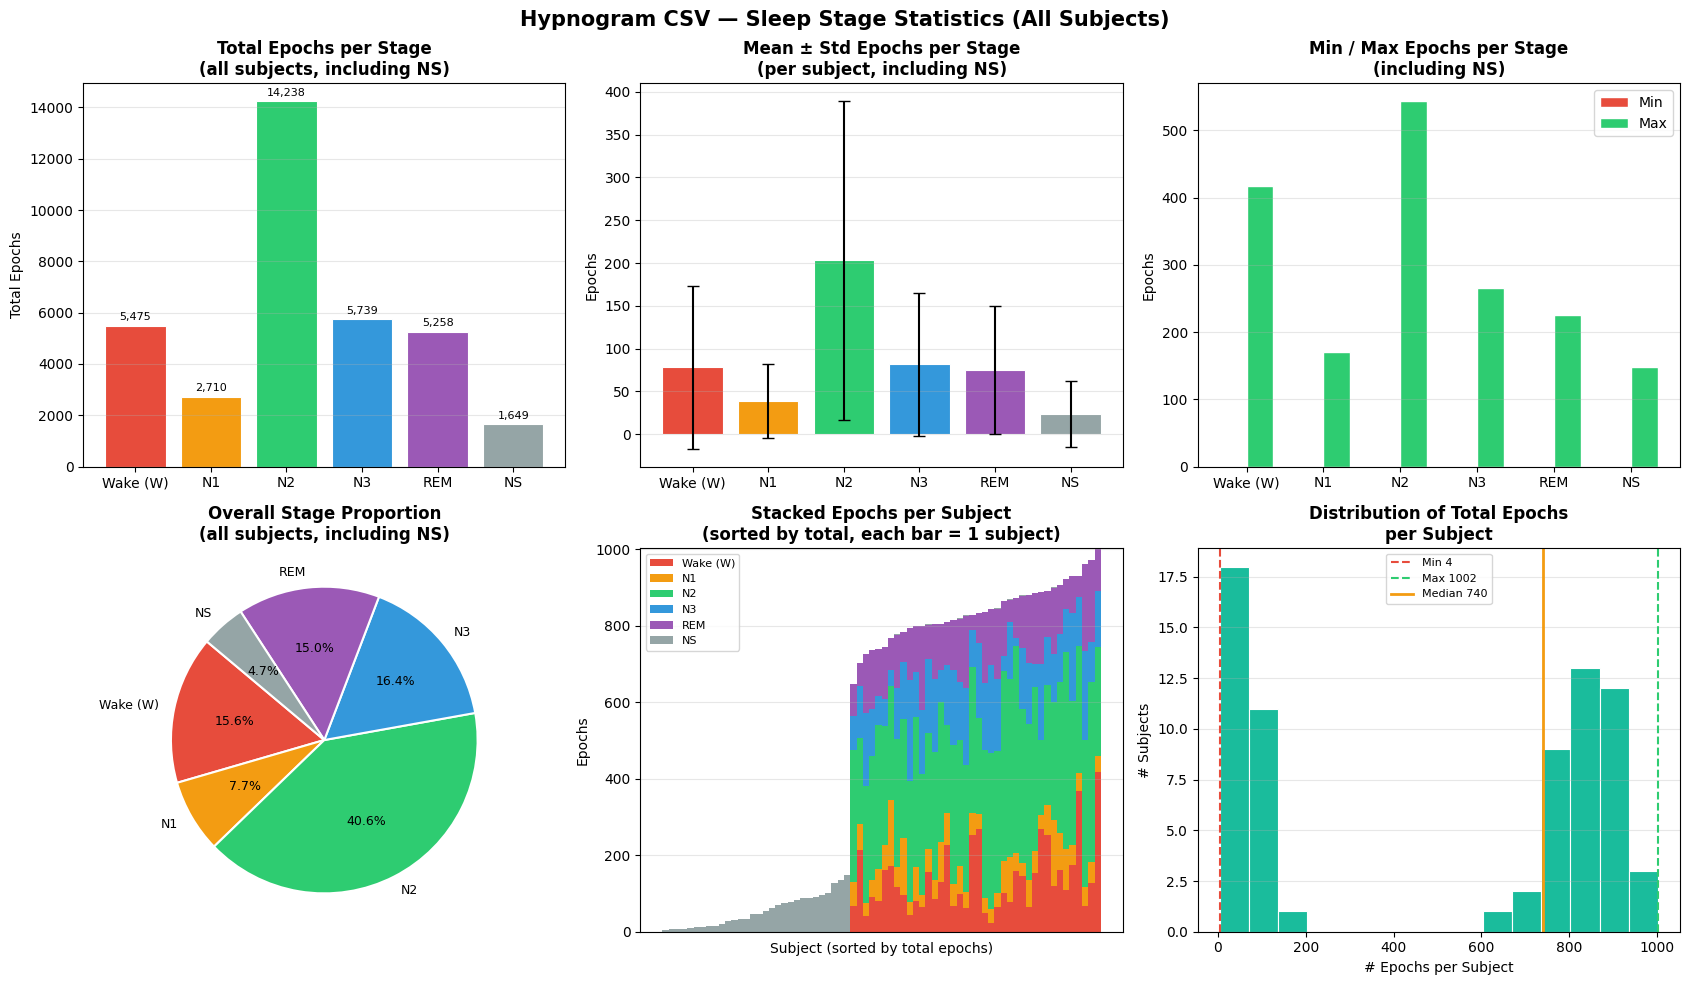

In [10]:
# ── Charts: Hypnogram / Sleep Stage Stats (รวม NS) ───────────────────────────
# รวม NS เข้าไปใน cols/labels/colors
stage_cols_all   = [f'stage_{s}' for s in range(5)] + ['stage_ns']
stage_labels_all = [STAGE_NAMES[s] for s in range(5)] + ['NS']
colors_all       = [STAGE_COLORS[s] for s in range(5)] + ['#95a5a6']

# กลุ่ม 5 stages สำหรับ charts ที่ไม่รวม NS
stage_cols   = stage_cols_all[:5]
stage_labels = stage_labels_all[:5]
colors       = colors_all[:5]

fig, axes = plt.subplots(2, 3, figsize=(17, 10))
fig.suptitle('Hypnogram CSV — Sleep Stage Statistics (All Subjects)', fontsize=15, fontweight='bold')

# ── 1. Total epoch count per stage (รวม NS) ───────────────────────────────────
ax = axes[0, 0]
totals_all = [df_hyp_all[c].sum() for c in stage_cols_all]
bars = ax.bar(stage_labels_all, totals_all, color=colors_all, edgecolor='white', linewidth=0.8)
ax.set_title('Total Epochs per Stage\n(all subjects, including NS)', fontweight='bold')
ax.set_ylabel('Total Epochs')
for bar, val in zip(bars, totals_all):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(totals_all)*0.01,
            f'{val:,}', ha='center', va='bottom', fontsize=8)
ax.grid(axis='y', alpha=0.3)

# ── 2. Mean ± Std per stage (รวม NS) ─────────────────────────────────────────
ax = axes[0, 1]
means = [df_hyp_all[c].mean() for c in stage_cols_all]
stds  = [df_hyp_all[c].std()  for c in stage_cols_all]
ax.bar(stage_labels_all, means, color=colors_all, edgecolor='white', linewidth=0.8,
       yerr=stds, error_kw={'linewidth': 1.5, 'capsize': 4, 'color': 'black'})
ax.set_title('Mean ± Std Epochs per Stage\n(per subject, including NS)', fontweight='bold')
ax.set_ylabel('Epochs')
ax.grid(axis='y', alpha=0.3)

# ── 3. Min / Max per stage (รวม NS) ──────────────────────────────────────────
ax = axes[0, 2]
x    = np.arange(len(stage_labels_all))
mins = [df_hyp_all[c].min() for c in stage_cols_all]
maxs = [df_hyp_all[c].max() for c in stage_cols_all]
w = 0.35
ax.bar(x - w/2, mins, width=w, color='#e74c3c', edgecolor='white', label='Min')
ax.bar(x + w/2, maxs, width=w, color='#2ecc71', edgecolor='white', label='Max')
ax.set_xticks(x)
ax.set_xticklabels(stage_labels_all)
ax.set_title('Min / Max Epochs per Stage\n(including NS)', fontweight='bold')
ax.set_ylabel('Epochs')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# ── 4. Pie chart: Overall stage proportion (รวม NS) ───────────────────────────
ax = axes[1, 0]
wedge_props = {'edgecolor': 'white', 'linewidth': 1.5}
totals_nonzero = [(lbl, val, col) for lbl, val, col in zip(stage_labels_all, totals_all, colors_all) if val > 0]
pie_labels, pie_vals, pie_colors = zip(*totals_nonzero) if totals_nonzero else ([], [], [])
ax.pie(pie_vals, labels=pie_labels, colors=pie_colors, autopct='%1.1f%%',
       startangle=140, wedgeprops=wedge_props, textprops={'fontsize': 9})
ax.set_title('Overall Stage Proportion\n(all subjects, including NS)', fontweight='bold')

# ── 5. Stacked bar per subject (รวม NS) ──────────────────────────────────────
ax = axes[1, 1]
df_sorted = df_hyp_all.sort_values('n_epochs').reset_index(drop=True)
bottom = np.zeros(len(df_sorted))
x_idx  = np.arange(len(df_sorted))
for col, lbl, color in zip(stage_cols_all, stage_labels_all, colors_all):
    vals = df_sorted[col].values
    ax.bar(x_idx, vals, bottom=bottom, color=color, label=lbl, width=1.0, linewidth=0)
    bottom += vals
ax.set_title('Stacked Epochs per Subject\n(sorted by total, each bar = 1 subject)', fontweight='bold')
ax.set_xlabel('Subject (sorted by total epochs)')
ax.set_ylabel('Epochs')
ax.legend(fontsize=8, loc='upper left')
ax.set_xticks([])
ax.grid(axis='y', alpha=0.3)

# ── 6. Epochs per subject histogram ──────────────────────────────────────────
ax = axes[1, 2]
ax.hist(df_hyp_all['n_epochs'], bins=15, color='#1abc9c', edgecolor='white', linewidth=0.8)
mn  = df_hyp_all['n_epochs'].min()
mx  = df_hyp_all['n_epochs'].max()
med = df_hyp_all['n_epochs'].median()
ax.axvline(mn,  color='#e74c3c', linestyle='--', linewidth=1.5, label=f'Min {int(mn)}')
ax.axvline(mx,  color='#2ecc71', linestyle='--', linewidth=1.5, label=f'Max {int(mx)}')
ax.axvline(med, color='#f39c12', linestyle='-',  linewidth=2.0, label=f'Median {int(med)}')
ax.set_title('Distribution of Total Epochs\nper Subject', fontweight='bold')
ax.set_xlabel('# Epochs per Subject')
ax.set_ylabel('# Subjects')
ax.legend(fontsize=8)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Unique Values Summary — Hypnogram CSV Columns

In [11]:
# ── สรุป unique values แต่ละ column ของ hypnogram CSV ─────────────────────────
print('=' * 65)
print('HYPNOGRAM CSV — Unique Values per Column (from sample subject)')
print('=' * 65)

hyp_sample_sid = None
for sid in subject_ids:
    p = os.path.join(RAW_EEG_DIR, sid, 'csv_hypnogram.csv')
    if os.path.exists(p):
        hyp_sample_sid = sid
        break

if hyp_sample_sid:
    df_s = pd.read_csv(os.path.join(RAW_EEG_DIR, hyp_sample_sid, 'csv_hypnogram.csv'))
    df_s.columns = df_s.columns.str.strip()

    for col in df_s.columns:
        uniq = df_s[col].unique().tolist()
        dtype = df_s[col].dtype
        print(f'\nColumn: "{col}"')
        print(f'  dtype        : {dtype}')
        print(f'  # unique     : {len(uniq)}')
        print(f'  sample values: {uniq[:10]}{"..." if len(uniq) > 10 else ""}')
        if 'stage' in col.lower():
            vc = df_s[col].str.strip().str.upper().value_counts()
            print(f'  value counts :')
            for v, c in vc.items():
                mapped = STAGE_MAP.get(v, None)
                if mapped is not None:
                    mapped_str = f'label {mapped} ({STAGE_NAMES[mapped]})'
                else:
                    mapped_str = 'NS (unmapped)'
                print(f'    {v:8s} → {mapped_str}  : {c} epochs')

print('\n' + '=' * 65)

# ── Stage token uniqueness across ALL subjects ────────────────────────────────
print()
print('Unique Sleep Stage Tokens across ALL subjects:')
token_counter = {}
for sid in subject_ids:
    hyp_path = os.path.join(RAW_EEG_DIR, sid, 'csv_hypnogram.csv')
    if not os.path.exists(hyp_path):
        continue
    df_t = pd.read_csv(hyp_path)
    df_t.columns = df_t.columns.str.strip()
    sc = next((c for c in df_t.columns if 'stage' in c.lower()), None)
    if sc:
        for v in df_t[sc].str.strip().str.upper().unique():
            token_counter[v] = token_counter.get(v, 0) + 1

print(f'  {"Token":<10}  {"Mapped To":<20}  {"# Subjects with token"}')
print('  ' + '-' * 52)
for token, cnt in sorted(token_counter.items(), key=lambda x: -x[1]):
    mapped = STAGE_MAP.get(token, None)
    if mapped is not None:
        mapped_str = f'label {mapped} ({STAGE_NAMES[mapped]})'
    else:
        mapped_str = 'NS (unmapped)'
    print(f'  {token:<10}  {mapped_str:<20}  {cnt}')

HYPNOGRAM CSV — Unique Values per Column (from sample subject)

Column: "Epoch Number"
  dtype        : int64
  # unique     : 29
  sample values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]...

Column: "Start Time"
  dtype        : object
  # unique     : 29
  sample values: ['5:22:25 AM', '5:22:55 AM', '5:23:25 AM', '5:23:55 AM', '5:24:25 AM', '5:24:55 AM', '5:25:25 AM', '5:25:55 AM', '5:26:25 AM', '5:26:55 AM']...

Column: "Sleep Stage"
  dtype        : object
  # unique     : 1
  sample values: ['NS']
  value counts :
    NS       → NS (unmapped)  : 29 epochs


Unique Sleep Stage Tokens across ALL subjects:
  Token       Mapped To             # Subjects with token
  ----------------------------------------------------
  NS          NS (unmapped)         43
  WK          label 0 (Wake (W))    40
  N1          label 1 (N1)          40
  N2          label 2 (N2)          40
  REM         label 4 (REM)         40
  N3          label 3 (N3)          40
